# 랭그래프 구축

In [1]:
# 기본 모듈 선언
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import HumanMessagePromptTemplate


In [2]:
from typing import Dict, TypedDict, Annotated, List, Union
from langchain import hub
from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_node import ToolNode# langgraph 관련 모듈


In [4]:
import sys, os

# 절대 경로로 프로젝트의 Feature_rag 폴더(또는 langgraph_structure의 부모)를 지정
proj_pkg_root = r"C:\dev\SKN18-4th-1team\Feature_rag"

if proj_pkg_root not in sys.path:
    sys.path.insert(0, proj_pkg_root)

# 확인용 출력
print("sys.path[0]:", sys.path[0])
import importlib
print("can import langgraph_structure?", importlib.util.find_spec("langgraph_structure") is not None)

sys.path[0]: C:\dev\SKN18-4th-1team\Feature_rag
can import langgraph_structure? True


In [5]:
from langgraph_structure.nodes.classify_node import classify_node, classify_quit
from langgraph_structure.nodes.eval_node import evaluate_chunk_node, classify_retrieval
from langgraph_structure.nodes.rewrite_question import rewrite_question, rewrite_question
from langgraph_structure.nodes.generation_llm import generation_llm_node, generation_llm
from langgraph_structure.nodes.search_hospital import search_hospital_node, search_hospital
from langgraph_structure.nodes.search_vectordb import search_node
from init_state import GraphState

{'question': '감기가 걸렸을 때 어떤 병원에 가야 하나요?', 'need_quit': False}


In [6]:
# 분기 결정을 위한 함수 정의
def classify_quit(state: Dict) -> str:
    """
    classify_node의 결과에 따라 다음 노드를 결정하는 함수
    need_quit이 True면 END로, False면 search_node로 이동
    """
    return END if state.get("need_quit") else "search_node"

In [7]:
# 그래프 생성을 위한 StateGraph import
from langgraph.graph import StateGraph, END
from typing import Dict, TypedDict, Annotated

# 상태 정의
# class GraphState(TypedDict):
#     question: str
#     context: str
#     answer: str
#     need_quit: bool

# 그래프 생성 함수
def create_graph_flow():
    # 그래프 초기화
    graph = StateGraph(GraphState)
    
    # 노드 선언
    graph.add_node("classify_node", classify_node)
    graph.add_node("search_node", search_node)
    graph.add_node("evaluate_chunk_node", evaluate_chunk_node)
    graph.add_node("rewrite_question_node", rewrite_question)
    graph.add_node("generation_llm_node", generation_llm_node)
    graph.add_node("search_hospital_node", search_hospital_node)
    
    # 엣지 선언 
    graph.set_entry_point("classify_node")
    graph.add_conditional_edges(
        "classify_node",
        classify_quit,
        {
            END: END,
            "search_node": "search_node"
        }
    )
    graph.add_edge("search_node", "evaluate_chunk_node")
    graph.add_conditional_edges(
        "evaluate_chunk_node",
        classify_retrieval,
        {
            END: END,
            "rewrite_question_node": "rewrite_question_node",
            "search_hospital_node": "search_hospital_node"
        }
    )
    graph.add_edge("rewrite_question_node", "classify_node")
    graph.add_edge("search_hospital_node", "generation_llm_node")
    graph.add_edge("generation_llm_node", END)
    
    return graph.compile()

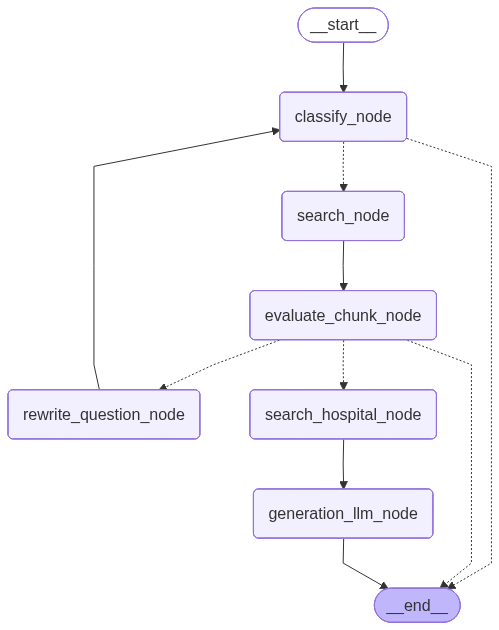

In [8]:
# 그래프 생성
rag_app = create_graph_flow()

# 그래프 시각화
from IPython.display import Image, display

try:
    display(
        Image(
            rag_app.get_graph().draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"그래프 표시 오류: {e}")